# A Tour of pyGAM

## Introduction

Generalized Additive Models (GAMs) are smooth semi-parametric models of the form:

$$
    g(\mathbb{E}[y|X]) = \beta_0 + f_1(X_1) + f_2(X_2, X_3) + \ldots + f_M(X_N)
$$

where `X.T = [X_1, X_2, ..., X_N]` are independent variables, `y` is the dependent variable, and `g()` is the link function that relates our predictor variables to the expected value of the dependent variable.

The feature functions `f_i()` are built using **penalized B splines**, which allow us to **automatically model non-linear relationships** without having to manually try out many different transformations on each variable.


![Basis splines](pygam_basis.png)

GAMs extend generalized linear models by allowing non-linear functions of features while maintaining additivity. Since the model is additive, it is easy to examine the effect of each `X_i` on `Y` individually while holding all other predictors constant.

The result is a very flexible model, where it is easy to incorporate prior knowledge and control overfitting.



## Generalized Additive Models, in general

$$
y \sim ExponentialFamily(\mu|X)
$$

where 
$$
g(\mu|X) = \beta_0 + f_1(X_1) + f_2(X_2, X_3) + \ldots + f_M(X_N)
$$

So we can see that a GAM has 3 components:

- ``distribution`` from the exponential family
- ``link function`` $g(\cdot)$
- ``functional form`` with an additive structure $\beta_0 + f_1(X_1) + f_2(X_2, X_3) + \ldots + f_M(X_N)$

### Distribution: 
Specified via: ``GAM(distribution='...')``

Currently you can choose from the following:

- `'normal'`
- `'binomial'`
- `'poisson'`
- `'gamma'`
- `'inv_gauss'`

### Link function: 
We specify this using: ``GAM(link='...')``

Link functions take the distribution mean to the linear prediction. So far, the following are available:

- `'identity'`
- `'logit'`
- `'inverse'`
- `'log'`
- `'inverse-squared'`


### Functional Form: 
Specified in ``GAM(terms=...)`` or more simply ``GAM(...)``

In pyGAM, we specify the functional form using terms:

- `l()` linear terms: for terms like $X_i$
- `s()` spline terms
- `f()` factor terms
- `te()` tensor products
- `intercept`  

With these, we can quickly and compactly build models like:

#### What is "inv_gauss" (Inverse Gaussian)?

The **Inverse Gaussian** (also called "inv_gauss") is a continuous, positively-skewed probability distribution used for modeling non-negative continuous data.  
It is often appropriate when modeling data where the variance increases with the square of the mean, such as the time to failure of a system or waiting times.

- The mean of the Inverse Gaussian is $\mu$, and the variance is $\lambda \mu^3$, where $\lambda$ is a shape parameter.
- In pyGAM, you can specify a GAM using the Inverse Gaussian distribution via `distribution='inv_gauss'`.

Typical use cases for the Inverse Gaussian include survival analysis, reliability engineering, and certain types of time-to-event data.




In [1]:
from pygam import GAM, s, te

GAM(s(0, n_splines=200) + te(3, 1) + s(2), distribution="poisson", link="log")

GAM(callbacks=['deviance', 'diffs'], distribution='poisson', 
   fit_intercept=True, link='log', max_iter=100, 
   terms=s(0) + te(3, 1) + s(2), tol=0.0001, verbose=False)

which specifies that we want a:

- spline function on feature 0, with 200 basis functions
- tensor spline interaction on features 1 and 3
- spline function on feature 2

Note:

``GAM(..., intercept=True)`` so models include an intercept by default.

### in Practice...
in **pyGAM** you can build custom models by specifying these 3 elements, **or** you can choose from **common models**:

- `LinearGAM` identity link and normal distribution
- `LogisticGAM` logit link and binomial distribution
- `PoissonGAM` log link and Poisson distribution
- `GammaGAM` log link and gamma distribution
- `InvGauss` log link and inv_gauss distribution

The benefit of the common models is that they have some extra features, apart from reducing boilerplate code.

## Terms and Interactions

pyGAM can also fit interactions using tensor products via `te()`

In [2]:
from pygam import PoissonGAM, s, te
from pygam.datasets import chicago

X, y = chicago(return_X_y=True)

gam = PoissonGAM(s(0, n_splines=200) + te(3, 1) + s(2)).fit(X, y)

and plot a 3D surface:

In [3]:
import matplotlib.pyplot as plt

plt.ion()
plt.rcParams["figure.figsize"] = (12, 8)

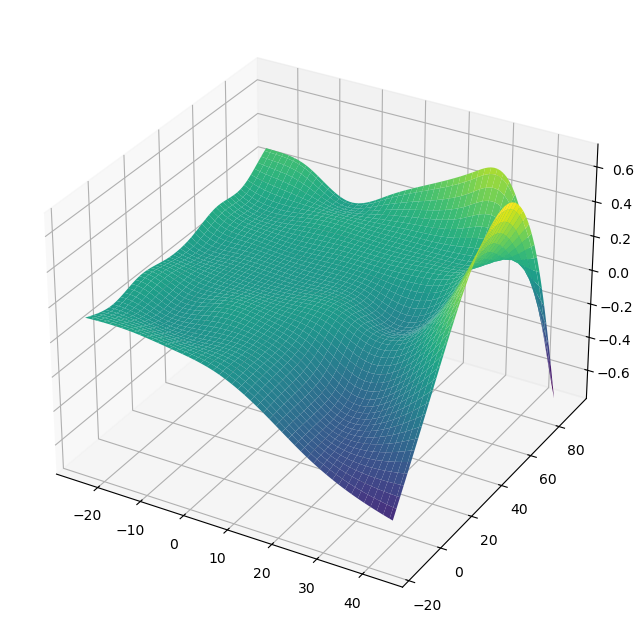

In [4]:
XX = gam.generate_X_grid(term=1, meshgrid=True)
Z = gam.partial_dependence(term=1, X=XX, meshgrid=True)

ax = plt.axes(projection="3d")
ax.plot_surface(XX[0], XX[1], Z, cmap="viridis")

For simple interactions it is sometimes useful to add a by-variable to a term

In [ ]:
from pygam import LinearGAM, s
from pygam.datasets import toy_interaction

X, y = toy_interaction(return_X_y=True)

gam = LinearGAM(s(0, by=1)).fit(X, y)
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     20.8449
Link Function:                     IdentityLink Log Likelihood:                              -2317525.6219
Number of Samples:                        50000 AIC:                                          4635094.9336
                                                AICc:                                         4635094.9536
                                                GCV:                                                  0.01
                                                Scale:                                                0.01
                                                Pseudo R-Squared:                                   0.9976
Feature Function                  Lam

## Regression

For **regression** problems, we can use a **linear GAM** which models:

$$
    \mathbb{E}[y|X]=\beta_0+f_1(X_1)+f_2(X_2, X_3)+\dots+f_M(X_N)
$$

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


<Figure size 864x576 with 0 Axes>

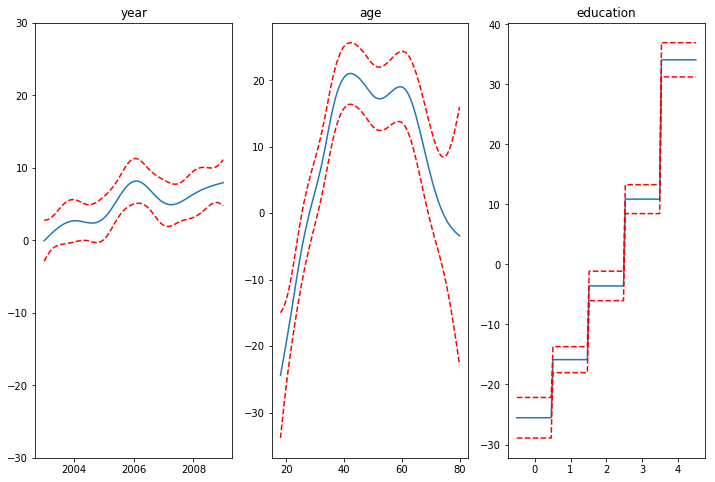

In [ ]:
from pygam import LinearGAM, f, s
from pygam.datasets import wage

X, y = wage(return_X_y=True)

## model
gam = LinearGAM(s(0) + s(1) + f(2))
gam.gridsearch(X, y)


## plotting
plt.figure()
fig, axs = plt.subplots(1, 3)
titles = ["year", "age", "education"]
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(
        XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c="r", ls="--"
    )
    if i == 0:
        ax.set_ylim(-30, 30)
    ax.set_title(titles[i])

Even though our model allows coefficients, our smoothing penalty reduces us to just 19 effective degrees of freedom:

In [ ]:
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.2602
Link Function:                     IdentityLink Log Likelihood:                                -24116.7451
Number of Samples:                         3000 AIC:                                            48274.0107
                                                AICc:                                           48274.2999
                                                GCV:                                             1250.3656
                                                Scale:                                           1235.9245
                                                Pseudo R-Squared:                                   0.2945
Feature Function                  Lam

With **LinearGAMs**, we can also check the **prediction intervals**:

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


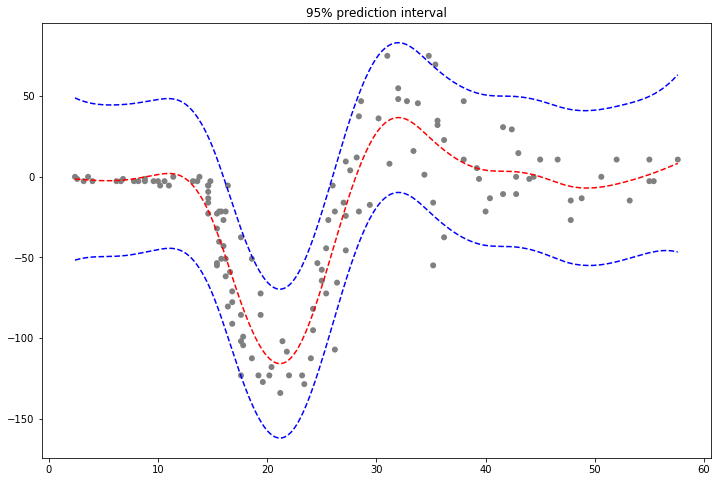

In [ ]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

gam = LinearGAM(n_splines=25).gridsearch(X, y)
XX = gam.generate_X_grid(term=0, n=500)

plt.plot(XX, gam.predict(XX), "r--")
plt.plot(XX, gam.prediction_intervals(XX, width=0.95), color="b", ls="--")

plt.scatter(X, y, facecolor="gray", edgecolors="none")
plt.title("95% prediction interval");

And simulate from the posterior:

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


Text(0.5,1,'draw samples from the posterior of the coefficients')

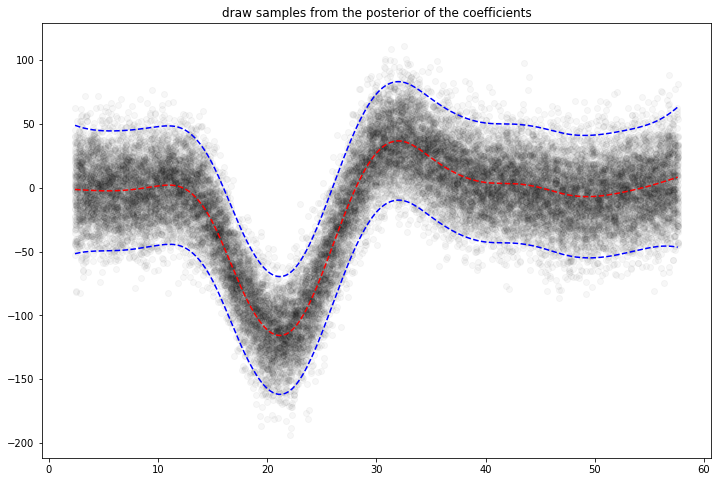

In [ ]:
# continuing last example with the mcycle dataset
for response in gam.sample(X, y, quantity="y", n_draws=50, sample_at_X=XX):
    plt.scatter(XX, response, alpha=0.03, color="k")
plt.plot(XX, gam.predict(XX), "r--")
plt.plot(XX, gam.prediction_intervals(XX, width=0.95), color="b", ls="--")
plt.title("draw samples from the posterior of the coefficients")

## Classification

For **binary classification** problems, we can use a **logistic GAM** which models:

$$
    log\left(\frac{P(y=1|X)}{P(y=0|X)}\right)=\beta_0+f_1(X_1)+f_2(X_2, X_3)+\dots+f_M(X_N)
$$

100% (11 of 11) |########################| Elapsed Time: 0:00:04 Time:  0:00:04


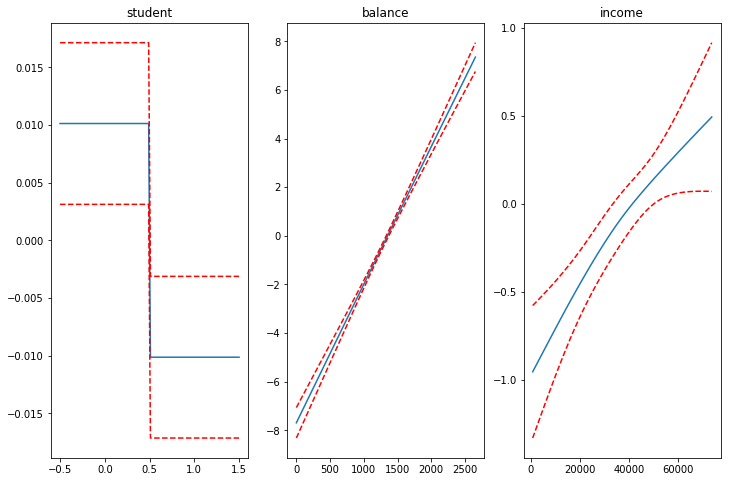

In [ ]:
from pygam import LogisticGAM, f, s
from pygam.datasets import default

X, y = default(return_X_y=True)

gam = LogisticGAM(f(0) + s(1) + s(2)).gridsearch(X, y)

fig, axs = plt.subplots(1, 3)
titles = ["student", "balance", "income"]

for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, width=0.95)

    ax.plot(XX[:, i], pdep)
    ax.plot(XX[:, i], confi, c="r", ls="--")
    ax.set_title(titles[i])

We can then check the accuracy:

In [ ]:
gam.accuracy(X, y)

0.9739

Since the **scale** of the **Binomial distribution** is known, our gridsearch minimizes the **Un-Biased Risk Estimator** (UBRE) objective:

In [ ]:
gam.summary()

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      3.8047
Link Function:                        LogitLink Log Likelihood:                                   -788.877
Number of Samples:                        10000 AIC:                                             1585.3634
                                                AICc:                                             1585.369
                                                UBRE:                                               2.1588
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.4598
Feature Function                  Lam

## Poisson and Histogram Smoothing
We can intuitively perform **histogram smoothing** by modeling the counts in each bin
as being distributed Poisson via **PoissonGAM**.

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


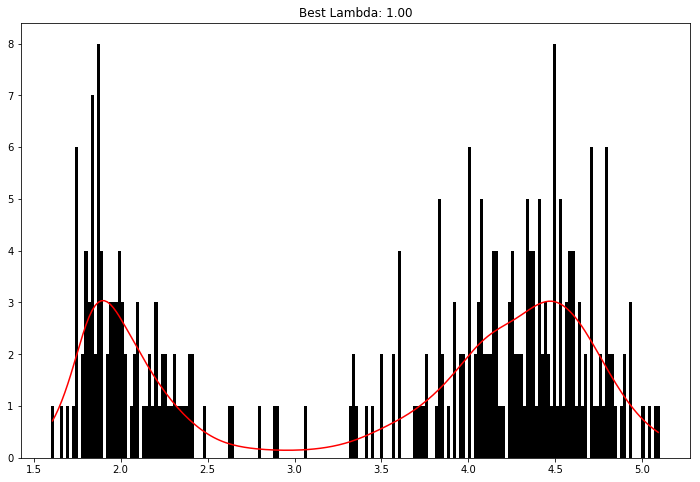

In [ ]:
from pygam import PoissonGAM
from pygam.datasets import faithful

X, y = faithful(return_X_y=True)

gam = PoissonGAM().gridsearch(X, y)

plt.hist(faithful(return_X_y=False)["eruptions"], bins=200, color="k")
plt.plot(X, gam.predict(X), color="r")
plt.title(f"Best Lambda: {gam.lam[0][0]:.2f}");

## Expectiles
GAMs with a Normal distribution suffer from the limitation of an assumed constant variance.
Sometimes this is not an appropriate assumption, because we'd like the variance of our error distribution to vary.  

In this case we can resort to modeling the **expectiles** of a distribution.   

Expectiles are intuitively similar to quantiles, but model tail expectations instead of tail mass. Although they are less interpretable, expectiles are **much** faster to fit, and can also be used to non-parametrically model a distribution.

In [ ]:
from pygam import ExpectileGAM
from pygam.datasets import mcycle

X, y = mcycle(return_X_y=True)

# lets fit the mean model first by CV
gam50 = ExpectileGAM(expectile=0.5).gridsearch(X, y)

# and copy the smoothing to the other models
lam = gam50.lam

# now fit a few more models
gam95 = ExpectileGAM(expectile=0.95, lam=lam).fit(X, y)
gam75 = ExpectileGAM(expectile=0.75, lam=lam).fit(X, y)
gam25 = ExpectileGAM(expectile=0.25, lam=lam).fit(X, y)
gam05 = ExpectileGAM(expectile=0.05, lam=lam).fit(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


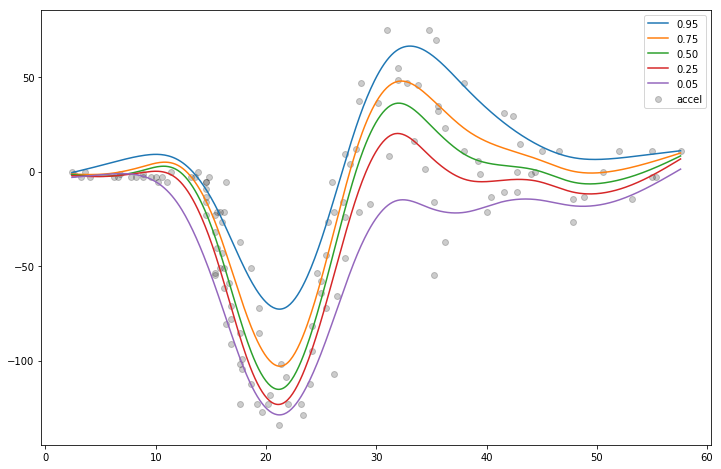

In [ ]:
XX = gam50.generate_X_grid(term=0, n=500)

plt.scatter(X, y, c="k", alpha=0.2)
plt.plot(XX, gam95.predict(XX), label="0.95")
plt.plot(XX, gam75.predict(XX), label="0.75")
plt.plot(XX, gam50.predict(XX), label="0.50")
plt.plot(XX, gam25.predict(XX), label="0.25")
plt.plot(XX, gam05.predict(XX), label="0.05")
plt.legend()

We fit the **mean model** by cross-validation in order to find the best smoothing parameter `lam` and then copy it over to the other models.

This practice makes the expectiles less likely to cross. 

## Custom Models

It's also easy to build custom models by using the base **GAM** class and specifying the **distribution** and the **link function**:

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Text(0,0.5,'predicted volume')

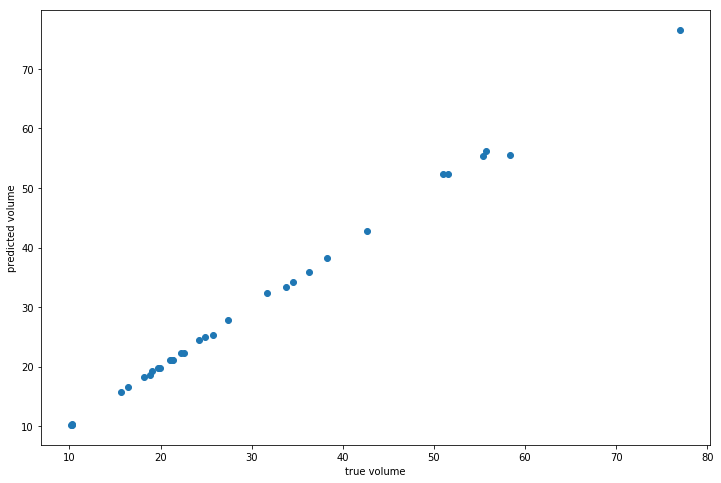

In [ ]:
from pygam import GAM
from pygam.datasets import trees

X, y = trees(return_X_y=True)

gam = GAM(distribution="gamma", link="log")
gam.gridsearch(X, y)

plt.scatter(y, gam.predict(X))
plt.xlabel("true volume")
plt.ylabel("predicted volume")

We can check the quality of the fit by looking at the Pseudo R-Squared:

In [ ]:
gam.summary()

GAM                                                                                                       
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                     25.3616
Link Function:                          LogLink Log Likelihood:                                   -26.1673
Number of Samples:                           31 AIC:                                              105.0579
                                                AICc:                                             501.5549
                                                GCV:                                                0.0088
                                                Scale:                                               0.001
                                                Pseudo R-Squared:                                   0.9993
Feature Function                  Lam

## Penalties / Constraints

With GAMs we can encode **prior knowledge** and **control overfitting** by using penalties and constraints.

**Available penalties**
- second derivative smoothing (default on numerical features)
- L2 smoothing (default on categorical features)

**Available constraints**
- monotonic increasing/decreasing smoothing
- convex/concave smoothing
- periodic smoothing [soon...]


We can inject our intuition into our model by using **monotonic** and **concave** constraints:


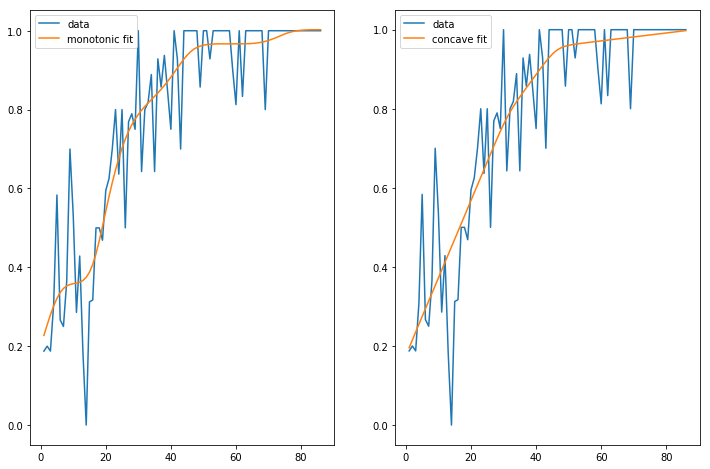

In [ ]:
from pygam import LinearGAM, s
from pygam.datasets import hepatitis

X, y = hepatitis(return_X_y=True)

gam1 = LinearGAM(s(0, constraints="monotonic_inc")).fit(X, y)
gam2 = LinearGAM(s(0, constraints="concave")).fit(X, y)

fig, ax = plt.subplots(1, 2)
ax[0].plot(X, y, label="data")
ax[0].plot(X, gam1.predict(X), label="monotonic fit")
ax[0].legend()

ax[1].plot(X, y, label="data")
ax[1].plot(X, gam2.predict(X), label="concave fit")
ax[1].legend()

## API

pyGAM is intuitive, modular, and adheres to a familiar API:

In [ ]:
from pygam import LogisticGAM, f, s
from pygam.datasets import toy_classification

X, y = toy_classification(return_X_y=True, n=5000)

gam = LogisticGAM(s(0) + s(1) + s(2) + s(3) + s(4) + f(5))
gam.fit(X, y)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, lam=[0.6, 0.6, 0.6, 0.6, 0.6, 0.6], 
   max_iter=100, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + f(5) + intercept, 
   tol=0.0001, verbose=False)

Since GAMs are additive, it is also super easy to visualize each individual **feature function**, `f_i(X_i)`. These feature functions describe the effect of each `X_i` on `y` individually while marginalizing out all other predictors:


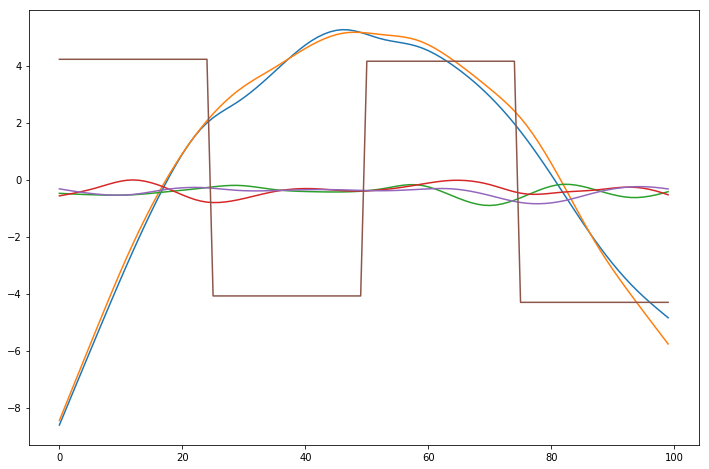

In [ ]:
plt.figure()
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    plt.plot(gam.partial_dependence(term=i))

## Current Features

### Models
pyGAM comes with many models out-of-the-box:

- GAM (base class for constructing custom models)
- LinearGAM
- LogisticGAM
- GammaGAM
- PoissonGAM
- InvGaussGAM
- ExpectileGAM

### Terms
- `l()` linear terms
- `s()` spline terms
- `f()` factor terms
- `te()` tensor products
- `intercept`

### Distributions

- Normal
- Binomial
- Gamma
- Poisson
- Inverse Gaussian

### Link Functions
Link functions take the distribution mean to the linear prediction. These are the canonical link functions for the above distributions:

- Identity
- Logit
- Inverse
- Log
- Inverse-squared

### Callbacks
Callbacks are performed during each optimization iteration. It's also easy to write your own.

- deviance - model deviance
- diffs - differences of coefficient norm
- accuracy - model accuracy for LogisticGAM
- coef - coefficient logging

You can check a callback by inspecting:


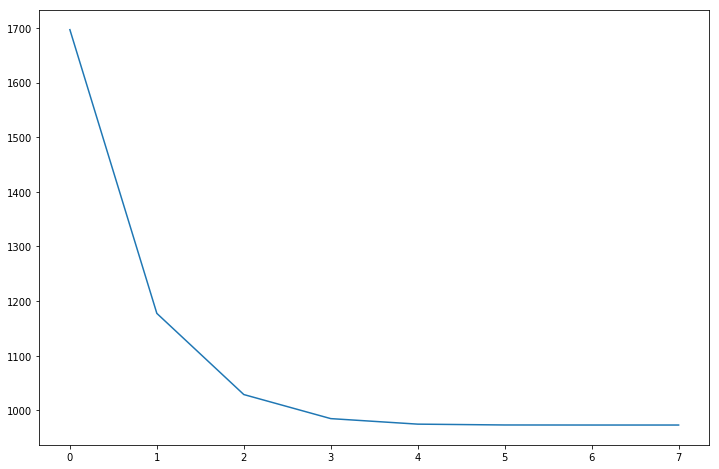

In [ ]:
_ = plt.plot(gam.logs_["deviance"])

### Linear Extrapolation

100% (11 of 11) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


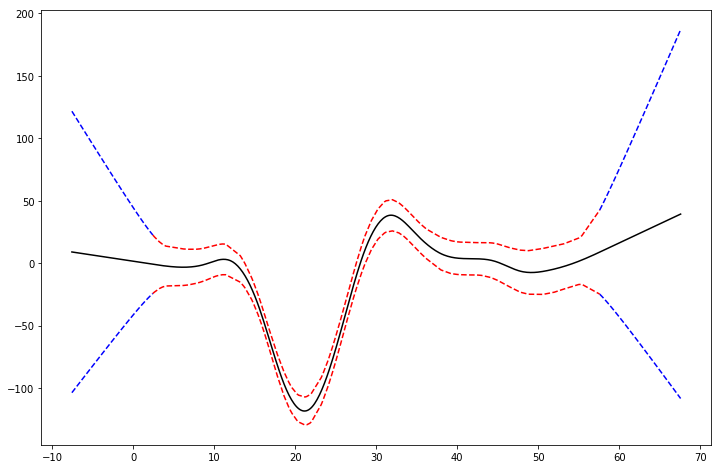

In [ ]:
from pygam import LinearGAM
from pygam.datasets import mcycle

X, y = mcycle()

gam = LinearGAM()
gam.gridsearch(X, y)

XX = gam.generate_X_grid(term=0)

m = X.min()
M = X.max()
XX = np.linspace(m - 10, M + 10, 500)
Xl = np.linspace(m - 10, m, 50)
Xr = np.linspace(M, M + 10, 50)

plt.figure()

plt.plot(XX, gam.predict(XX), "k")
plt.plot(Xl, gam.confidence_intervals(Xl), color="b", ls="--")
plt.plot(Xr, gam.confidence_intervals(Xr), color="b", ls="--")
_ = plt.plot(X, gam.confidence_intervals(X), color="r", ls="--")

## References
1. Simon N. Wood, 2006  
Generalized Additive Models: an introduction with R

0. Hastie, Tibshirani, Friedman  
The Elements of Statistical Learning  
https://www.sas.upenn.edu/~fdiebold/NoHesitations/BookAdvanced.pdf  

0. James, Witten, Hastie and Tibshirani  
An Introduction to Statistical Learning  
http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Sixth%20Printing.pdf  

0. Paul Eilers & Brian Marx, 1996
Flexible Smoothing with B-splines and Penalties  
http://statweb.lsu.edu/faculty/marx/StatScience.pdf

0. Kim Larsen, 2015  
GAM: The Predictive Modeling Silver Bullet  
http://multithreaded.stitchfix.com/assets/files/gam.pdf  

0. Deva Ramanan, 2008  
UCI Machine Learning: Notes on IRLS  
http://www.ics.uci.edu/~dramanan/teaching/ics273a_winter08/homework/irls_notes.pdf  

0. Paul Eilers & Brian Marx, 2015  
International Biometric Society: A Crash Course on P-splines  
http://www.ibschannel2015.nl/project/userfiles/Crash_course_handout.pdf

0. Keiding, Niels, 1991  
Age-specific incidence and prevalence: a statistical perspective  
https://academic.oup.com/jrsssa/article-abstract/154/3/371/7106499
